<a href="https://colab.research.google.com/github/gobeomgyu/deeplearning/blob/main/Phone_CNN_Les_trans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

#기본 경로 설정
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset/UCI HAR Dataset'

def load_file(filepath):
    # delim_whitespace=True 대신 sep=r'\s+' 써도 됨
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [ ]:
# 여러 파일을 불러서 (샘플, time_step, feature) 형태로 쌓기
def load_group(filenames, prefix=''):
    loaded = []
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # (샘플, time_step, feature)
    loaded = np.dstack(loaded)
    return loaded

# train 또는 test 한 묶음 불러오기
def load_dataset_group(group, prefix=''):
    filepath = prefix + '/' + group + '/Inertial Signals/'
    # 센서 9개
    filenames = []
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt',  'body_acc_y_'+group+'.txt',  'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']

    X = load_group(filenames, filepath)
    y = load_file(prefix + '/' + group + '/y_'+group+'.txt')
    return X, y

# 전체 데이터셋 불러오기
def load_dataset(prefix=BASE_PATH):
    trainX, trainy = load_dataset_group('train', prefix)
    testX,  testy  = load_dataset_group('test',  prefix)

    # 레이블을 0부터 시작하게
    trainy = trainy - 1
    testy  = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot  = to_categorical(testy)

    print('trainX:', trainX.shape,
          'trainy:', trainy.shape,
          'testX:', testX.shape,
          'testy:', testy.shape)

    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

/tmp/ipython-input-171910126.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-171910126.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-171910126.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-171910126.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


trainX: (7352, 128, 9) trainy: (7352, 1) testX: (2947, 128, 9) testy: (2947, 1)


/tmp/ipython-input-171910126.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-171910126.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


In [ ]:
# train을 다시 train/val로 분리
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, test_size=0.2, random_state=100, stratify=trainy_one_hot
)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# 입력/출력 차원
n_timesteps = X_train.shape[1]   # 보통 128
n_features  = X_train.shape[2]   # 9
n_outputs   = y_train.shape[1]   # 6 class


(5881, 128, 9) (1471, 128, 9) (5881, 6) (1471, 6)


In [ ]:
# 심플 CNN 모델
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense

In [ ]:
model = Sequential()
# 첫번째 컨볼루션
model.add(Conv1D(filters=64,
                 kernel_size=3,
                 activation='relu',
                 input_shape=(n_timesteps, n_features)))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# 다운샘플링
model.add(MaxPooling1D(pool_size=2))
# 과적합 방지
model.add(Dropout(0.5))
# 일렬로 펴기
model.add(Flatten())
# 완전연결
model.add(Dense(100, activation='relu'))
# 출력층
model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 126, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 124, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3968)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │       396,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,650 (1.57 MB)

 Trainable params: 411,650 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.7017 - loss: 0.7439 - val_accuracy: 0.9150 - val_loss: 0.2139
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9265 - loss: 0.1879 - val_accuracy: 0.9402 - val_loss: 0.1389
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9500 - loss: 0.1288 - val_accuracy: 0.9449 - val_loss: 0.1456
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9515 - loss: 0.1208 - val_accuracy: 0.9565 - val_loss: 0.1129
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9507 - loss: 0.1156 - val_accuracy: 0.9579 - val_loss: 0.1016
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9630 - loss: 0.0911 - val_accuracy: 0.9524 - val_loss: 0.1181
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9561 - loss: 0.1040 - val_accuracy: 0.9572 - val_loss: 0.0966
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9637 - loss: 0.0874 - val_accu

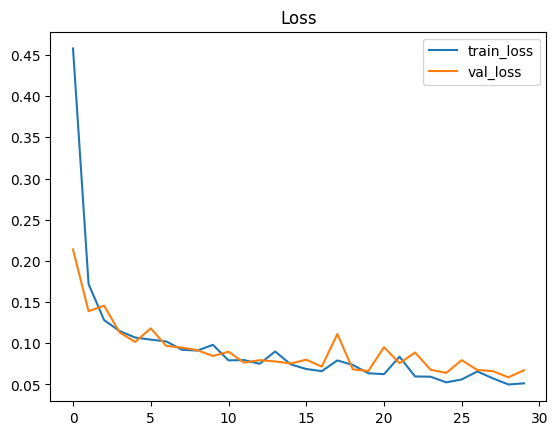

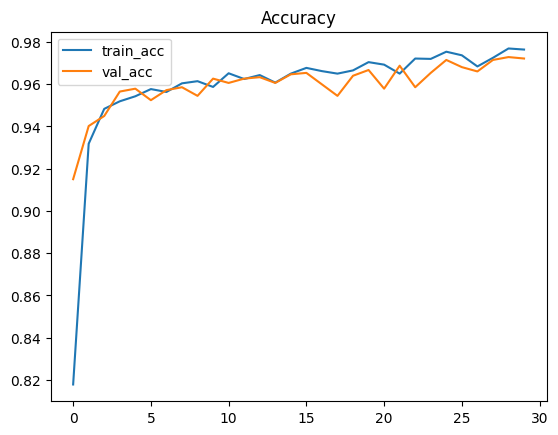

In [ ]:
# 학습
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

# 학습 곡선 그리기
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
test accuracy: 0.9277231082456736
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       496
           1       0.95      0.94      0.94       471
           2       0.91      0.99      0.95       420
           3       0.85      0.81      0.83       491
           4       0.88      0.86      0.87       532
           5       0.99      1.00      0.99       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



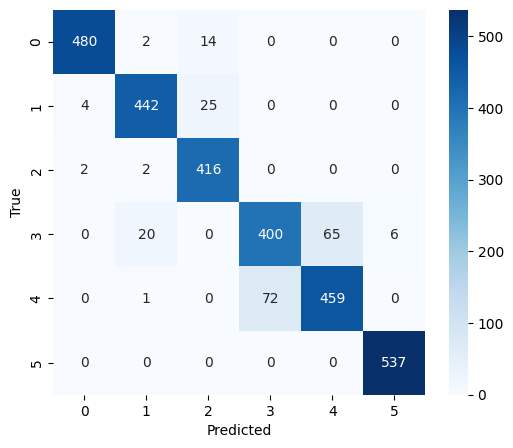

In [ ]:
# 테스트셋 평가 + 혼동행렬
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_pred_prob = model.predict(testX)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = testy.ravel()  # (2947,1) -> (2947,)

cm = confusion_matrix(y_true, y_pred)
print("test accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

# train + test 한 덩어리로 합치기
X_all = np.concatenate([trainX, testX], axis=0)
y_all = np.concatenate([trainy, testy], axis=0)           # (N,1)
y_all_oh = np.concatenate([trainy_one_hot, testy_one_hot], axis=0)
y_all_label = y_all.ravel()

n_timesteps = X_all.shape[1]
n_features  = X_all.shape[2]
n_outputs   = y_all_oh.shape[1]

# 2) Stratified K-Fold 준비
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# 모델 만드는 함수들
# ============================================================

from tensorflow.keras import layers, models
import tensorflow as tf

# 심플 CNN을 함수로 래핑
def make_simple_cnn(n_timesteps, n_features, n_outputs):
    m = models.Sequential()
    m.add(layers.Conv1D(64, 3, activation='relu', input_shape=(n_timesteps, n_features)))
    m.add(layers.Conv1D(64, 3, activation='relu'))
    m.add(layers.MaxPooling1D(2))
    m.add(layers.Dropout(0.5))
    m.add(layers.Flatten())
    m.add(layers.Dense(100, activation='relu'))
    m.add(layers.Dense(n_outputs, activation='softmax'))
    m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return m

# ResNet 블록
def resnet_block(x, filters, kernel_size=3):
    shortcut = x
    x = layers.Conv1D(filters, kernel_size, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv1D(filters, 1, padding='same')(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

# 1D ResNet
def make_resnet_1d(n_timesteps, n_features, n_outputs):
    inputs = layers.Input(shape=(n_timesteps, n_features))
    x = layers.Conv1D(64, 7, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling1D(2)(x)

    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    x = layers.MaxPooling1D(2)(x)

    x = resnet_block(x, 128)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(n_outputs, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Transformer encoder
def transformer_encoder(x, num_heads, key_dim, ff_dim, dropout=0.1):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    attn = layers.Dropout(dropout)(attn)
    x = layers.LayerNormalization(epsilon=1e-6)(x + attn)

    ffn = layers.Dense(ff_dim, activation='relu')(x)
    ffn = layers.Dense(x.shape[-1])(ffn)
    ffn = layers.Dropout(dropout)(ffn)
    x = layers.LayerNormalization(epsilon=1e-6)(x + ffn)
    return x

# Transformer 1D
def make_transformer_1d(n_timesteps, n_features, n_outputs):
    inputs = layers.Input(shape=(n_timesteps, n_features))

    # 간단 위치 임베딩
    positions = tf.range(start=0, limit=n_timesteps, delta=1)
    pos_embed = layers.Embedding(input_dim=n_timesteps, output_dim=n_features)(positions)
    pos_embed = tf.expand_dims(pos_embed, 0)
    x = inputs + pos_embed   # broadcasting

    x = transformer_encoder(x, num_heads=4, key_dim=n_features, ff_dim=128)
    x = transformer_encoder(x, num_heads=4, key_dim=n_features, ff_dim=128)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(n_outputs, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# ResNet + Transformer
def make_resnet_transformer(n_timesteps, n_features, n_outputs):
    inputs = layers.Input(shape=(n_timesteps, n_features))

    x = layers.Conv1D(64, 7, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)

    seq_len = x.shape[1]
    positions = tf.range(start=0, limit=seq_len, delta=1)
    pos_embed = layers.Embedding(input_dim=seq_len, output_dim=64)(positions)
    pos_embed = tf.expand_dims(pos_embed, 0)
    x = x + pos_embed

    x = transformer_encoder(x, num_heads=4, key_dim=64, ff_dim=128)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(n_outputs, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# k-fold 돌리는 공통 함수
# ============================================================
def run_kfold_with_model(make_model_fn, model_name,
                         X_all, y_all_oh, y_all_label, skf,
                         epochs=20, batch_size=64):
    print(f"\n================= {model_name} K-FOLD =================")
    fold = 1
    acc_list = []
    for train_idx, val_idx in skf.split(X_all, y_all_label):
        X_tr, X_val = X_all[train_idx], X_all[val_idx]
        y_tr, y_val = y_all_oh[train_idx], y_all_oh[val_idx]

        model = make_model_fn(n_timesteps, n_features, n_outputs)

        model.fit(
            X_tr, y_tr,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            verbose=0
        )

        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_val, axis=1)

        acc = accuracy_score(y_true, y_pred)
        acc_list.append(acc)
        print(f"[{model_name}] fold {fold} acc: {acc:.4f}")
        print(classification_report(y_true, y_pred))
        fold += 1

    print(f"========== {model_name} mean acc: {np.mean(acc_list):.4f} ==========\n")

In [ ]:
# 이제 4가지 모델을 차례대로 돌려보기
# ============================================================

# 원래 구조랑 비슷한 심플 CNN
run_kfold_with_model(make_simple_cnn, "Simple CNN",
                     X_all, y_all_oh, y_all_label, skf,
                     epochs=15, batch_size=64)

# ResNet 1D
run_kfold_with_model(make_resnet_1d, "ResNet-1D",
                     X_all, y_all_oh, y_all_label, skf,
                     epochs=15, batch_size=64)

# Transformer 1D
run_kfold_with_model(make_transformer_1d, "Transformer-1D",
                     X_all, y_all_oh, y_all_label, skf,
                     epochs=15, batch_size=64)

# ResNet + Transformer
run_kfold_with_model(make_resnet_transformer, "ResNet+Transformer",
                     X_all, y_all_oh, y_all_label, skf,
                     epochs=15, batch_size=64)


================= Simple CNN K-FOLD =================


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
[Simple CNN] fold 1 acc: 0.9665
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       344
           1       0.99      1.00      0.99       309
           2       1.00      0.99      1.00       281
           3       0.93      0.88      0.91       355
           4       0.90      0.94      0.92       382
           5       1.00      1.00      1.00       389

    accuracy                           0.97      2060
   macro avg       0.97      0.97      0.97      2060
weighted avg       0.97      0.97      0.97      2060



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
[Simple CNN] fold 2 acc: 0.9680
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       344
           1       1.00      1.00      1.00       309
           2       1.00      1.00      1.00       281
           3       0.95      0.87      0.91       356
           4       0.89      0.95      0.92       381
           5       1.00      1.00      1.00       389

    accuracy                           0.97      2060
   macro avg       0.97      0.97      0.97      2060
weighted avg       0.97      0.97      0.97      2060



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
[Simple CNN] fold 3 acc: 0.9583
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       345
           1       1.00      0.99      0.99       309
           2       1.00      0.99      1.00       281
           3       0.88      0.90      0.89       356
           4       0.91      0.88      0.89       381
           5       1.00      1.00      1.00       388

    accuracy                           0.96      2060
   macro avg       0.96      0.96      0.96      2060
weighted avg       0.96      0.96      0.96      2060



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
[Simple CNN] fold 4 acc: 0.9583
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       345
           1       0.99      0.99      0.99       309
           2       1.00      1.00      1.00       281
           3       0.87      0.90      0.89       355
           4       0.91      0.87      0.89       381
           5       1.00      1.00      1.00       389

    accuracy                           0.96      2060
   macro avg       0.96      0.96      0.96      2060
weighted avg       0.96      0.96      0.96      2060



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
[Simple CNN] fold 5 acc: 0.9626
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       344
           1       1.00      1.00      1.00       308
           2       1.00      1.00      1.00       282
           3       0.88      0.91      0.90       355
           4       0.92      0.88      0.90       381
           5       1.00      1.00      1.00       389

    accuracy                           0.96      2059
   macro avg       0.96      0.97      0.96      2059
weighted avg       0.96      0.96      0.96      2059

========== Simple CNN mean acc: 0.9627 ==========


================= ResNet-1D K-FOLD =================
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
[ResNet-1D] fold 1 acc: 0.9010
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       344
           1       1.00      1.00      1.00       309
           2       1.00      1.00      1.00    